In [1]:
import datetime as dt
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from scipy.interpolate import make_interp_spline, BSpline

from consts_and_funcs import *

# Record
let's look at my records, divided into time categories

the data was fetched as json, with number of wins, losses and draws, divided into categories


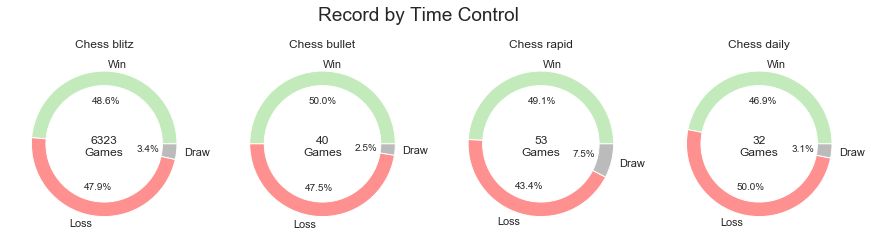

In [2]:
with open('datasets/stats.json', 'r') as f:
    stats = json.load(f)

record = {key: stats[key]['record'] for key in stats if 'record' in stats[key]}
for key in record:
    for value in record[key]:
        record[key] = {k: v for k, v in record[key].items() if k in ('win', 'loss', 'draw')}

colors = {'win': '#c3eabb', 'draw': '#bbbbbb', 'loss': '#ff9090'}

def create_record_chart(ax, key):
    data = record[key]
    values = list(data.values())
    labels = list(data.keys())
    ax.pie(values, labels=[x.capitalize() for x in labels], colors=[colors[x] for x in labels], autopct='%.1f%%')
    circle = plt.Circle((0,0), 0.80, fc='white')
    ax.add_artist(circle)
    ax.text(0, -.15, (str(sum(values)) + '\nGames'), ha='center', fontsize=12)
    ax.set_title(' '.join(key.split('_')).capitalize())

fig, axes = plt.subplots(1,4)
fig.set_size_inches((15, 4))
for ax, key in zip(axes.flatten()[::-1], record):  # record and axes are of same length
    create_record_chart(ax, key)
fig.suptitle('Record by Time Control', fontsize=19)
plt.savefig('plots/WinPercentagebyTimeClass.png', dpi=300)

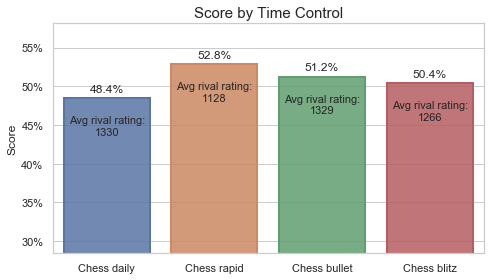

In [9]:
def get_score(d):
    pts = d['win'] + (d['draw'] / 2)
    return pts / sum(d.values())

df = pd.DataFrame(record).T
    

df['score'] = (df.win + (df.draw * .5)) * 100 / df.sum(axis=1)

ax = sns.barplot(df.index, 'score', data=df)
ax.set_xticklabels([' '.join(x.get_text().split('_')).capitalize() for x in ax.get_xticklabels()])
ax.set_ylim(df.score.min() - 20, min(df.score.max() + 10, df.score.max() * 1.1))

for p in ax.patches:
    # text for the scores
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + .5, f'{p.get_height():.1f}%', va='bottom', ha='center', fontsize=12)
    p.set_edgecolor(p.get_facecolor()) # coloring the bars' edges
    p.set_facecolor(p.get_facecolor()[:3] + (0.85,))  # adding alpha of 85%
    p.set_linewidth(2)
    
g = games.groupby('time_class').rival_rating.mean()
g.index = [f'chess_{x}' for x in g.index]

for idx, val in zip(range(10), g):
    ax.text(idx, df.iloc[idx]['score'] - 5,
            f'Avg rival rating:\n{val:.0f}'.center(17),
            va='bottom', ha='center', fontsize=11)  # text of the Avg rival rating
    
ax.set_title('Score by Time Control', fontsize=15)
ax.set_ylabel('Score')

ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))


ax.figure.set_size_inches(7, 4)
plt.tight_layout()
plt.savefig('plots/ScoreByTimecontrol.png', dpi=300)

# Games
The core of this analysis will be made on this table

This table has loads of data in several levels of depth and I will try to extract the most out of it

In [3]:
games = pd.read_csv('datasets/games.csv', index_col='game_id', parse_dates=True)
games['end_time'] = games.end_time.astype(np.datetime64)

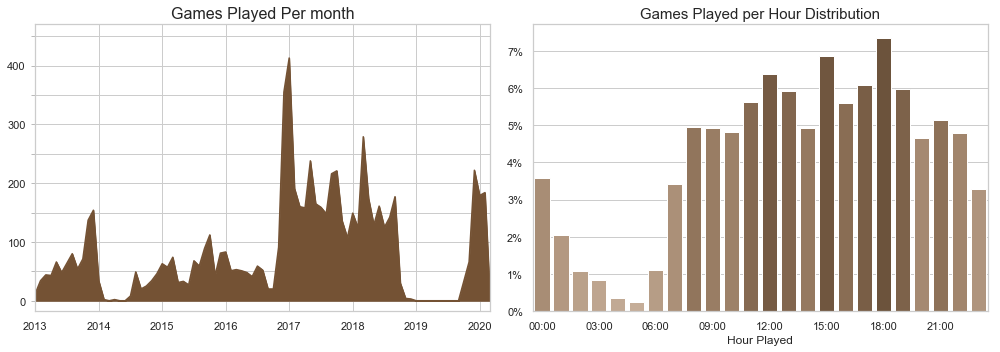

In [31]:
months = games.end_time.apply(lambda x: dt.datetime(year=x.year, month=x.month, day=1)) #truncate the months to make bins
blitz_games = games.time_class == 'blitz'
monthly_games = games.loc[blitz_games]\
                     .groupby(months)\
                     .size().astype(np.int32)

# add months with no games
monthly_games = monthly_games.reindex(pd.DatetimeIndex(pd.date_range('2013-01-01', dt.date.today(), freq='MS'))) 
monthly_games = monthly_games.fillna(0)

#palette
pal = browns(len(monthly_games))

fig, ax = plt.subplots(1, 2)
ax, ax1 = ax[0], ax

# Months ax

clr = [x*255 for x in pal[-1]]
monthly_games.plot.area(color=to_rgb(clr), ax=ax)

ax.set_ylim(-18, 470)
ax.set_title('Games Played Per month', fontsize=16)

ticks = monthly_games.index
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.tick_params(axis='y', which='minor', color='#bbbbbb', left=True)
ax.grid(True, which='minor', axis='y')

# Hours ax
ax, ax1 = ax1[1], ax1

g_hours = games.end_time.apply(lambda x: x.hour if x else None)

all_games = games.copy()
play_times = all_games.groupby(g_hours).size()
play_times = play_times.transform(lambda x: x * 100 / x.sum())  # turn numbers into percent

ranks = play_times.argsort().argsort()  # transforms array to ranks
pal = browns(len(play_times))  # palette

sns.barplot(x=play_times.index, y=play_times,
            palette=np.array(pal)[ranks],
            ax=ax)

ax.set_xticklabels([f'{x:02}:00' if x % 3 == 0 else '' for x in range(24)])

ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))

ax.set_title('Games Played per Hour Distribution', fontsize=15)
ax.set_xlabel('Hour Played')

fig.set_size_inches(14, 5)

plt.tight_layout()
plt.savefig('plots/GamesPerMonth.png', dpi=300)

In [32]:
# gets the amount of games played between 2016/10 and 2018/11, for the article
all_games = games.copy()
f_time = (dt.datetime(2016, 10, 1) < games.end_time) & (games.end_time < dt.datetime(2018, 11, 1))
all_games.loc[f_time, 'end_time'].size

4307

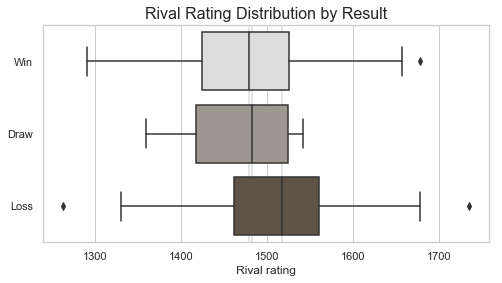

In [130]:
last_year = games.loc[f_last_year].copy()

z_score = last_year.rival_rating.transform(lambda x: (x - x.mean())/x.std())
last_year = last_year.loc[abs(z_score) <= 4]

pal = [to_rgb(x) for x in [c_white, (c_black+c_white)/2, c_black]]

ax = sns.boxplot('rival_rating', 'won', data=last_year, order=['win', 'draw', 'loss'], zorder=1, palette=pal)

for p in ax.patches:
    p.set
rival_rating = last_year.groupby('won')['rival_rating'].median()
for cat in rival_rating:
    ax.axvline(cat, color='#dddddd', zorder=0)
    
ax.set_yticklabels([x.get_text().capitalize() for x in ax.get_yticklabels()])
ax.set_ylabel('')

ax.set_xlabel(' '.join(ax.get_xlabel().split('_')).capitalize())
    
ax.set_title('Rival Rating Distribution by Result', fontsize=16)
ax.figure.set_size_inches(8,4)
    
plt.savefig('plots/RivalDistbyRes.png', dpi=300)

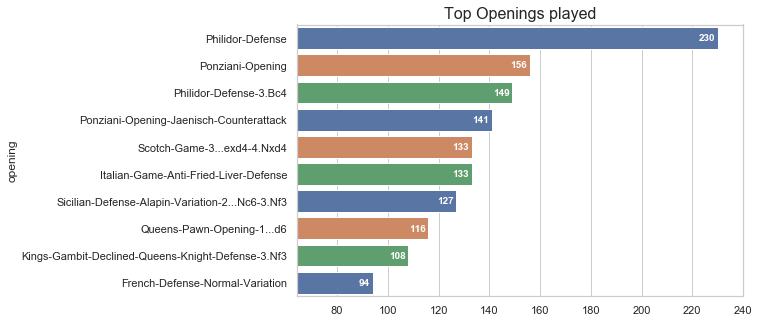

In [53]:
openings = games.groupby('opening')\
            .size()\
            .sort_values(ascending=False)\
            .head(10)

ax = sns.barplot(openings, openings.index, palette=sns.color_palette()[:3])
for p in ax.patches:
    ax.text(p.get_width() - 1,
            p.get_y() + p.get_height()/2,
            int(p.get_width()),
            va='center', ha='right',
            color='white', weight='bold')
    
ax.set_xlim(openings.min() - 30, openings.max() + 10)

ax.set_title('Top Openings played', fontsize=16)

ax.figure.set_size_inches(8, 5)

plt.savefig('plots/TopOpeningsOverall.png', dpi=300)

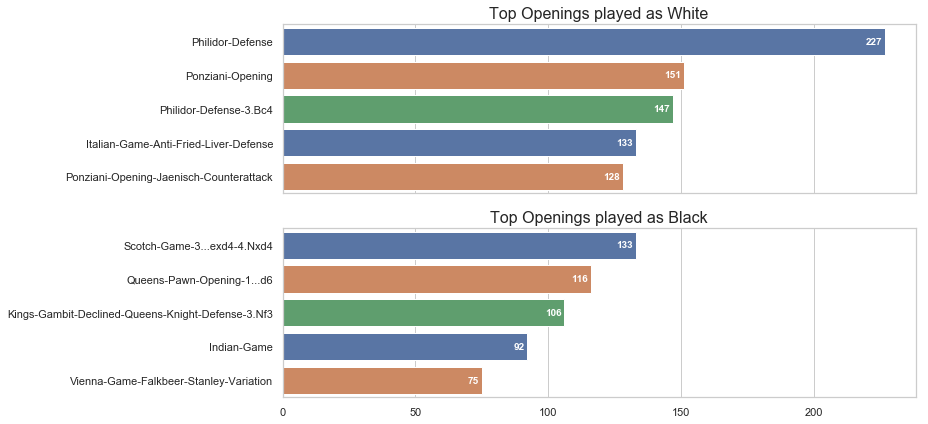

In [347]:
f_1450 = games.rival_rating >= 1450

fig, ax = plt.subplots(2, 1, sharex=True)

def plot_openings(color, ax):
    fil = games.color_played == color
    data = color_openings(fil)
    sns.barplot(data, data.index, ax=ax, palette=sns.color_palette()[:3])
    for p in ax.patches:
        ax.text(p.get_width() - 1,
        p.get_y() + p.get_height()/2,
        int(p.get_width()),
        va='center', ha='right',
        color='white', weight='bold')
        
    xlim = ax.get_xlim()
    lower_bound = max(0, data.min() - 30)
    upper_bound = min(data.max() + 10, data.max()*1.15)
    ax.set_xlim(min(xlim[0], lower_bound), max(xlim[1], upper_bound))
    ax.set_ylabel('')
    ax.set_title(f'Top Openings played as {color}', fontsize=16)
    
    
white_openings = plot_openings('White', ax[0])
black_openings = plot_openings('Black', ax[1])

ax[0].figure.set_size_inches(13, 6)
plt.tight_layout()

plt.savefig('plots/TopOpeningsColors.png', dpi=300)

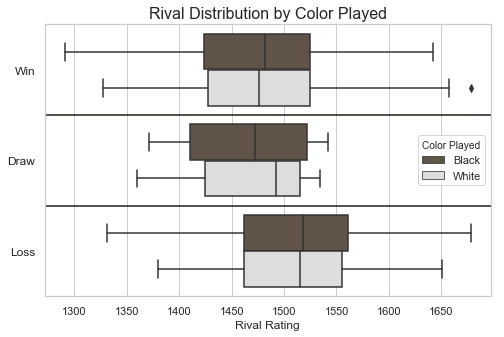

In [37]:
last_year = games.loc[f_last_year].copy()

pal = [to_rgb(color) for color in [c_black, c_white]]

# eliminate outliers
z_score = last_year.groupby(['won', 'color_played'])['rival_rating'].transform(lambda x: (x - x.mean()) / x.std())
last_year = last_year.loc[abs(z_score) <= 3].reset_index()


ax = sns.boxplot(x='rival_rating', y='won', hue='color_played',
            data=last_year, palette=pal,
            order=['win', 'draw', 'loss'])

ax.set_title('Rival Distribution by Color Played', fontsize=16)


ax.set_ylabel('')
ax.legend_.set_title('Color Played')
ax.set_xlabel('Rival Rating')
ax.set_yticklabels(['Win', 'Draw', 'Loss'], fontsize=12)

ax.axhline(0.5, color=to_rgb(c_black*.3))
ax.axhline(1.5, color=to_rgb(c_black*.3))

ax.figure.set_size_inches(8,5)

plt.savefig('plots/RivalDistbyColor.png', dpi=300)


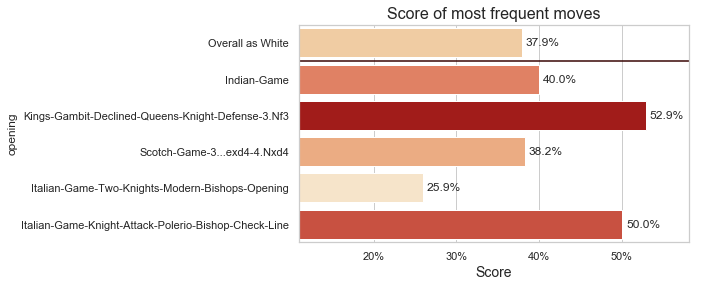

In [60]:
data = scores.sort_values('end_time', ascending=False).score.head()
data['Overall as White'] = overall_score
data *= 100

pal = np.array(sns.color_palette('OrRd'))

data = data.reindex(['Overall as White'] + data.index[:-1].to_list())  # move 'Overall as white' to the top

ranks = data.argsort().argsort()

ax = sns.barplot(data, data.index, palette=pal[ranks],)

ax.axhline(.5, color=pal[-1]*.3)

ax.set_xlim(max(0, data.min() - 15), min(data.max() + 10, data.max()*1.1))

for p in ax.patches:
    ax.text(p.get_width() + .5, p.get_height() / 2 + p.get_y(), f'{p.get_width():.1f}%', va='center', fontsize=12)
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.set_xlabel('Score', fontsize=14)

ax.set_title('Score of most frequent moves', fontsize=16)

# plt.tight_layout()
ax.figure.set_size_inches(7, 4)
plt.savefig('plots/WhiteOpeningsScore.png', dpi=300)

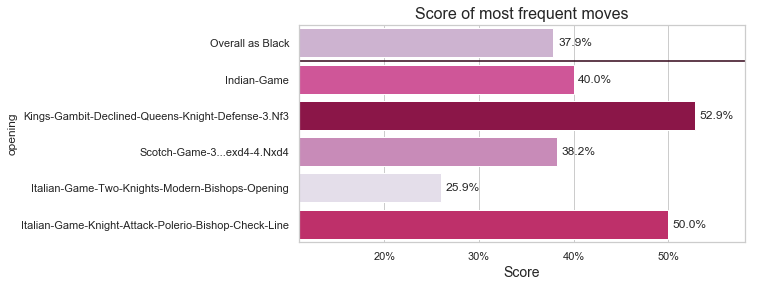

In [61]:
all_games = games.copy()


all_games['score'] = all_games.won.apply(chess_scores)

scores = all_games.loc[f_black & f_1450].groupby('opening').agg({'score': np.mean, 'end_time': np.count_nonzero})

overall_score = (scores.end_time * scores.score).sum() / scores.end_time.sum()

data = scores.sort_values('end_time', ascending=False).score.head()
data['Overall as Black'] = overall_score
data *= 100

pal = np.array(sns.color_palette('PuRd'))

data = data.reindex(['Overall as Black'] + data.index[:-1].to_list())  # move 'Overall as Black' to top

ranks = data.argsort().argsort()  # transform array into ranks

ax = sns.barplot(data, data.index, palette=pal[ranks],)

ax.axhline(.5, color=pal[-1]*.3)

ax.set_xlim(max(0, data.min() - 15), min(data.max() + 10, data.max()*1.1))

for p in ax.patches:
    ax.text(p.get_width() + .5, p.get_height() / 2 + p.get_y(), f'{p.get_width():.1f}%', va='center', fontsize=12)
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.set_xlabel('Score', fontsize=14)

ax.set_title('Score of most frequent moves', fontsize=16)

ax.figure.set_size_inches(8, 4)
plt.savefig('plots/BlackOpeningsScore.png', dpi=300)